# Vehicle Sales Dataset Exploration, Analyses and Price Prediction
### project in work

Dataset taken from: https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data

possible remaining clean-up possibilities with respect to the underlying data:
- use of abbreviations, for example in the body or model category
- 'manually' replace null values in the make and model columns based on the vin number
- extract further information provided by the vin number, for example country of origin

In [1]:
import torch
from dateutil import parser
import itertools
import math
import pandas as pd
import numpy as np
import seaborn as sns
from dython.nominal import associations
import association_metrics as am
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from scipy import stats

from statistics import mean 
from sklearn.metrics import r2_score, mean_squared_error
from torchmetrics.regression import R2Score, MeanSquaredError
import random
import os
import datetime
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

C:\Users\Nadine\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Dataset Description (taken from Kaggle):
The "Vehicle Sales and Market Trends Dataset" provides a comprehensive collection of information pertaining to the sales transactions of various vehicles. This dataset encompasses details such as the year, make, model, trim, body type, transmission type, VIN (Vehicle Identification Number), state of registration, condition rating, odometer reading, exterior and interior colors, seller information, Manheim Market Report (MMR) values, selling prices, and sale dates.

In [2]:
data_cars=pd.read_csv('data/car_prices/car_prices.csv')
pd.set_option('display.max_columns', None)
data_cars.head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)


In [3]:
data_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


558837 entries total
the attributes year, state, seller are the only ones with no null values

In [4]:
# drop entries that contain NaN values for any attribute
data_cars = data_cars.dropna(how='any',axis=0) 

In [5]:
data_cars.describe().T

,count,mean,std,min,25%,50%,75%,max
year,472325.0,2010.210980,3.822151,1990.0,2008.0,2012.0,2013.0,2015.0
condition,472325.0,30.774177,13.286866,1.0,24.0,35.0,41.0,49.0
odometer,472325.0,66701.732040,51939.586894,1.0,28137.0,51085.0,96590.0,999999.0
mmr,472325.0,13837.058964,9532.229273,25.0,7425.0,12300.0,18300.0,182000.0
sellingprice,472325.0,13690.512058,9613.033738,1.0,7200.0,12200.0,18200.0,230000.0


The lowest selling price is 1 while the highest selling price is 230000.
The oldest vehicle is from 1990 and the newest from 2015.

In [6]:
data_cars.describe(exclude=np.number).T

,count,unique,top,freq
make,472325,53,Ford,81013
model,472325,768,Altima,16346
trim,472325,1494,Base,48779
body,472325,85,Sedan,174647
transmission,472325,2,automatic,455963
vin,472325,465768,wp0ca2988xu629622,4
state,472325,34,fl,75243
color,472325,20,black,93244
interior,472325,17,black,209865
seller,472325,11923,ford motor credit company llc,17756


In [7]:
data_cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472325 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          472325 non-null  int64  
 1   make          472325 non-null  object 
 2   model         472325 non-null  object 
 3   trim          472325 non-null  object 
 4   body          472325 non-null  object 
 5   transmission  472325 non-null  object 
 6   vin           472325 non-null  object 
 7   state         472325 non-null  object 
 8   condition     472325 non-null  float64
 9   odometer      472325 non-null  float64
 10  color         472325 non-null  object 
 11  interior      472325 non-null  object 
 12  seller        472325 non-null  object 
 13  mmr           472325 non-null  float64
 14  sellingprice  472325 non-null  float64
 15  saledate      472325 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 61.3+ MB


In [8]:
gk = data_cars.groupby('body').apply(list)
gk = list(gk.index)

gk = [x.lower() for x in gk]
len(gk) == len(set(gk))

False

Check for case sensitivity in vehicle body values. 
The vehicle body attribute contains values that exist in different cases (lower and upper case)

In [9]:
string_attr = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller']

for attr in string_attr:
    data_cars[attr] = data_cars[attr].str.lower()


data_cars.head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)


- Transform all attribute values containing strings to lower case
- transmission only contains two unique values so a conversion is not necessary
- vin is not used in any analytics so a conversion is not necessary

In [10]:
data_cars.describe(exclude=np.number).T

,count,unique,top,freq
make,472325,53,ford,81013
model,472325,764,altima,16346
trim,472325,1475,base,48780
body,472325,45,sedan,211298
transmission,472325,2,automatic,455963
vin,472325,465768,wp0ca2988xu629622,4
state,472325,34,fl,75243
color,472325,20,black,93244
interior,472325,17,black,209865
seller,472325,11923,ford motor credit company llc,17756


The manufacturer Ford is the most frequently occuring manufyturer in the dataset with 81013 vehicles.
The vehicle body Sedan appears most frequently in the dataset, with 211298 entries.
The state with the most vehicles sold in ist Florida with 75243 sales.
The most frequent vehicle color is black with 93244 entries.
The Ford Motor Credit Company LLC is the seller with the most vehicle sales (17756).

### Check for duplicates

no duplicate entries found

In [11]:
data_cars[data_cars.duplicated()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate


### Plot distribution of numerical attributes

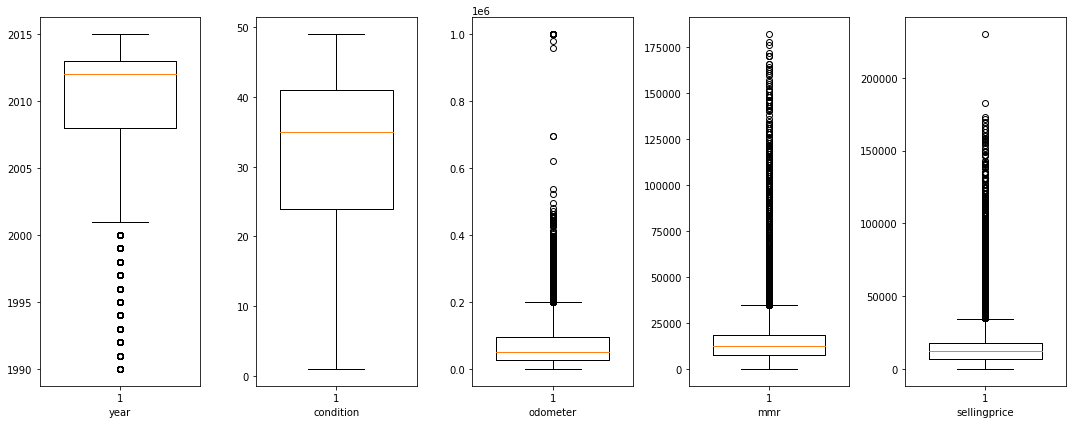

In [12]:
attrs = {}
for column in data_cars.select_dtypes(include=np.number):
    if column not in attrs:
        attrs[column] = data_cars[column]


fig, axes = plt.subplots(1, len(attrs), figsize =(15, 6))
i = 0
for attr in attrs:
    axes[i].boxplot(data_cars[attr], widths=[0.7])
    axes[i].set_xlabel(attr)
    i += 1

fig.tight_layout()
plt.show()


### Apply continuous label encoding to attributes containing categorical values

In [13]:
data_cars['makeID'] = data_cars['make'].astype('category')
data_cars['makeID'] = data_cars['makeID'].cat.codes

data_cars['modelID'] = data_cars['model'].astype('category')
data_cars['modelID'] = data_cars['modelID'].cat.codes

data_cars['trimID'] = data_cars['trim'].astype('category')
data_cars['trimID'] = data_cars['trimID'].cat.codes

data_cars['bodyID'] = data_cars['body'].astype('category')
data_cars['bodyID'] = data_cars['bodyID'].cat.codes

data_cars['transmissionID'] = data_cars['transmission'].astype('category')
data_cars['transmissionID'] = data_cars['transmissionID'].cat.codes

data_cars['stateID'] = data_cars['state'].astype('category')
data_cars['stateID'] = data_cars['stateID'].cat.codes

data_cars['colorID'] = data_cars['color'].astype('category')
data_cars['colorID'] = data_cars['colorID'].cat.codes

data_cars['interiorID'] = data_cars['interior'].astype('category')
data_cars['interiorID'] = data_cars['interiorID'].cat.codes

data_cars['sellerID'] = data_cars['seller'].astype('category')
data_cars['sellerID'] = data_cars['sellerID'].cat.codes

### Apply Normalisation to numerical data
not applied to selling price and market value (mmr) as they will not be used as independent variables during later prediction tasks

In [14]:
from sklearn.preprocessing import StandardScaler

for column in data_cars.select_dtypes(include=np.number):
    scaler = StandardScaler()
    data_cars[[f'{column}_Scaled']] = scaler.fit_transform(data_cars[[column]])

data_cars.head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,makeID,modelID,trimID,bodyID,transmissionID,stateID,colorID,interiorID,sellerID,year_Scaled,condition_Scaled,odometer_Scaled,mmr_Scaled,sellingprice_Scaled,makeID_Scaled,modelID_Scaled,trimID_Scaled,bodyID_Scaled,transmissionID_Scaled,stateID_Scaled,colorID_Scaled,interiorID_Scaled,sellerID_Scaled
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),24,637,865,39,0,2,17,1,5943,1.252966,-1.939826,-0.963866,0.698992,0.812386,0.152939,1.418707,0.231101,0.638263,-0.189432,-1.12273,1.137788,-0.703100,-0.014487
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),24,637,865,39,0,2,17,0,5943,1.252966,-1.939826,-1.103374,0.730464,0.812386,0.152939,1.418707,0.231101,0.638263,-0.189432,-1.12273,1.137788,-0.946825,-0.014487


### Get a list of the transformed attributes' names

In [15]:
numerical_attributes = []
categ_attributes = []
used_features = []
for attr in data_cars.select_dtypes(include=np.number):
    if not 'ID' in attr and not 'Scaled' in attr:
        numerical_attributes.append(attr)
    if 'ID'in attr and not 'ID_Scaled' in attr:
        categ_attributes.append(attr)
    if 'Scaled' in attr:
        used_features.append(attr)
        
used_features.remove('sellingprice_Scaled')
used_features.remove('mmr_Scaled')
print(used_features)
print(categ_attributes)

['year_Scaled', 'condition_Scaled', 'odometer_Scaled', 'makeID_Scaled', 'modelID_Scaled', 'trimID_Scaled', 'bodyID_Scaled', 'transmissionID_Scaled', 'stateID_Scaled', 'colorID_Scaled', 'interiorID_Scaled', 'sellerID_Scaled']
['makeID', 'modelID', 'trimID', 'bodyID', 'transmissionID', 'stateID', 'colorID', 'interiorID', 'sellerID']


### Convert saledate values to datetime format where possible

In [16]:
import dateparser
data_cars['saledate'] = pd.to_datetime(data_cars['saledate'], utc=True, errors='coerce')


C:\Users\Nadine\AppData\Local\Temp\ipykernel_17916\801982786.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_cars['saledate'] = pd.to_datetime(data_cars['saledate'], utc=True, errors='coerce')


In [17]:
data_cars['saledate'].dtype

datetime64[ns, UTC]

### Delete all remaining entries that still contain any null values due to errors during datetime conversion

In [18]:
data_cars = data_cars.dropna(how='any',axis=0) 

### Add new attribute 'age' calculated based on difference between manufacturing year and sale year

# Explorative analysis

### Analysing continuous numerical vehicle attributes

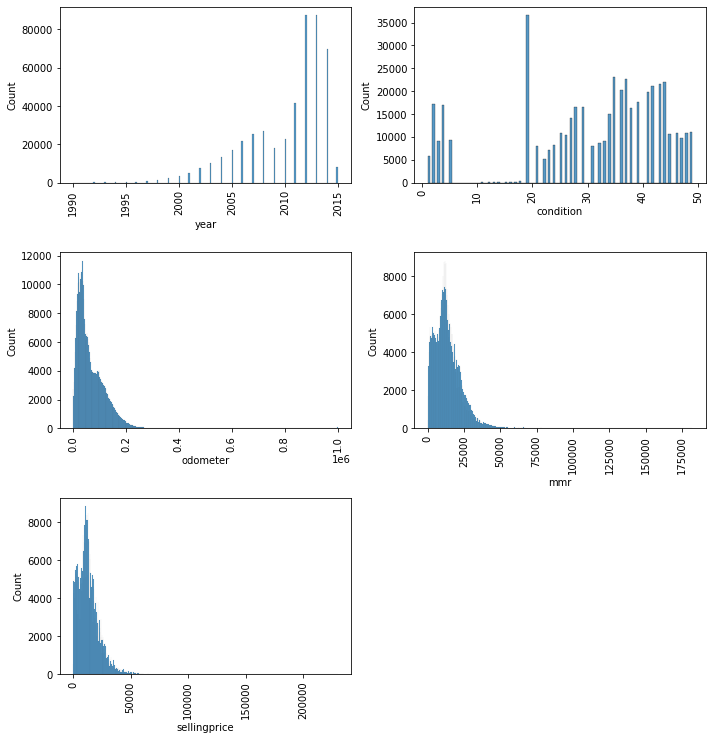

In [19]:
i=1
plt.figure(figsize=(10,10))
for attr in ['year', 'condition', 'odometer', 'mmr', 'sellingprice']:
    plt.subplot(3,2,i)
    sns.histplot(data_cars[attr])
    plt.tight_layout()
    plt.xticks(rotation=90)
    #plt.title('')
    i+=1

- most vehicles in the dataset are from the years 2012 or 2013. The plot is right-skewed with mostly recently built vehicles
- The histplot for the condition attribute seems to show missing values between 6 and 10 and 20, 30, 40 or 50. We will check this by having a look at the distinct condition values from the dataset.
- the hist plots for the odometer (mileage), mmr (market value) and selling price are very left-skewed, with the majority of values being on the lower end of each individual scale but also containing a few high-value outliers.

In [20]:
data_cars['condition'].value_counts().sort_index()

condition
1.0      5805
2.0     17248
3.0      9190
4.0     17078
5.0      9414
11.0       79
12.0       86
13.0       74
14.0      116
15.0      116
16.0      151
17.0      209
18.0      290
19.0    36647
21.0     8002
22.0     5235
23.0     7131
24.0     8154
25.0    10943
26.0    10370
27.0    14173
28.0    16650
29.0    16433
31.0     7942
32.0     8654
33.0     9176
34.0    15096
35.0    23209
36.0    20164
37.0    22680
38.0    16393
39.0    17567
41.0    19889
42.0    21094
43.0    21593
44.0    22091
45.0    10688
46.0    10822
47.0     9743
48.0    10884
49.0    11046
Name: count, dtype: int64

We can prove that there are no vehicles in the dataset that received a condition rationg between 6 and 10 or 20, 30, 40 or 50. To check the possibility of two different condition rating scales (1-5 and 10-50) we plot the relation between condition and selling price.

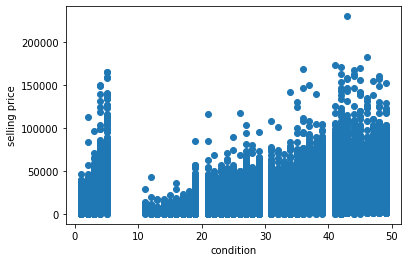

In [21]:
plt.scatter(data_cars['condition'], data_cars['sellingprice'])
plt.ylabel("selling price")
plt.xlabel("condition")
plt.show()

We see some kind of positive relationship between condition and selling price even though there are Vehicles for all condition stages that receive low selling prices. We can also see that the condition 1-5 area looks very similar to the condition 10-50 area which support our hypothesis that the dataset includes two different rating scales. We will fix this by converting the 1-5 condition scale to the 10-50 scale.

In [22]:
data_cars['condition'] = np.where(data_cars['condition']<10, data_cars['condition']*10, data_cars['condition'])

#### Apply Standard Scaler to newly changed condition data

In [24]:
scaler = StandardScaler()
data_cars[['condition_Scaled']] = scaler.fit_transform(data_cars[['condition']])
data_cars.head(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,makeID,modelID,trimID,bodyID,transmissionID,stateID,colorID,interiorID,sellerID,year_Scaled,condition_Scaled,odometer_Scaled,mmr_Scaled,sellingprice_Scaled,makeID_Scaled,modelID_Scaled,trimID_Scaled,bodyID_Scaled,transmissionID_Scaled,stateID_Scaled,colorID_Scaled,interiorID_Scaled,sellerID_Scaled
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,50.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,2014-12-16 04:30:00+00:00,24,637,865,39,0,2,17,1,5943,1.252966,1.667351,-0.963866,0.698992,0.812386,0.152939,1.418707,0.231101,0.638263,-0.189432,-1.12273,1.137788,-0.703100,-0.014487
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,50.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,2014-12-16 04:30:00+00:00,24,637,865,39,0,2,17,0,5943,1.252966,1.667351,-1.103374,0.730464,0.812386,0.152939,1.418707,0.231101,0.638263,-0.189432,-1.12273,1.137788,-0.946825,-0.014487


### Plotting relationships between continuous numerical vehicle attributes

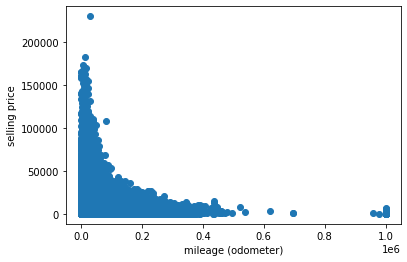

In [25]:
plt.scatter(data_cars['odometer'], data_cars['sellingprice'])
plt.ylabel("selling price")
plt.xlabel("mileage (odometer)")
plt.show()

the relationship between mileage (odometer) and selling price is a more monotonic than linear, negative relationship between selling price and mileage. The plot proves the difference in correlation coefficients between Pearson (linear) and Spearman (monotonic) correlation: -0.58 (Pearson) and -0.70 (Spearman)


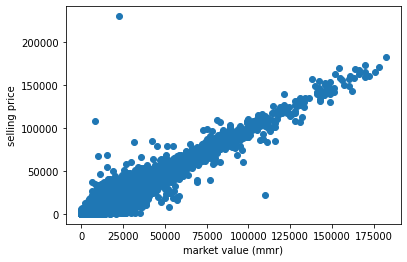

In [26]:
plt.scatter(data_cars['mmr'], data_cars['sellingprice'])
plt.ylabel("selling price")
plt.xlabel("market value (mmr)")
plt.show()

The scatter plot shows a very strong, positive relationship between selling price and market value. The identical values of Pearson and Spearman correlation coefficients indicates that is makes no difference, whether the correlation is calculated using the actual attribute values or the associated value ranks.

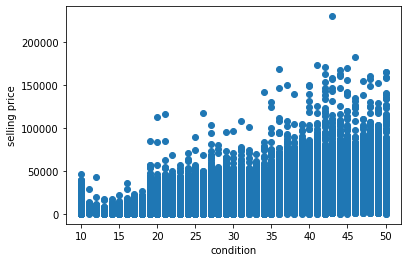

In [27]:
plt.scatter(data_cars['condition'], data_cars['sellingprice'])
plt.ylabel("selling price")
plt.xlabel("condition")
plt.show()

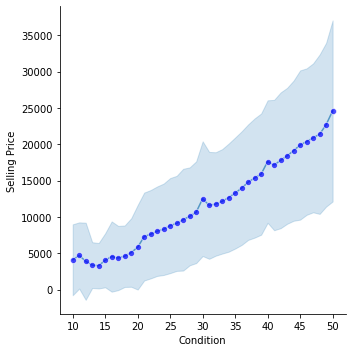

In [28]:
sns.relplot(
    x="condition",
    y="sellingprice",
    kind="line",
    data=data_cars,
    marker="o",
    alpha=0.7,
    markerfacecolor="blue",
    errorbar='sd'
)

plt.xlabel("Condition")
plt.ylabel("Selling Price")
plt.show()

Using the newly scaled condition rating, we can see a stronger positive relationship between condition and selling price. The higher the condition, the higher the maximum prices vehicles in the condition category received.
There are still vehicles for all condition stages that receive lower selling prices.

In [29]:
data_cars.groupby('condition')['sellingprice'].describe()

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
10.0,5805.0,4111.261326,4877.633494,100.0,650.0,2000.0,6500.0,46300.0
11.0,79.0,4706.202532,4551.704120,375.0,1450.0,3400.0,7100.0,29000.0
12.0,86.0,3909.593023,5304.500266,225.0,1325.0,2500.0,5012.5,43000.0
13.0,74.0,3381.081081,3146.858650,300.0,1325.0,2550.0,4650.0,17000.0
14.0,116.0,3292.672414,3123.976384,100.0,1200.0,2500.0,4100.0,17100.0
15.0,116.0,4043.965517,3716.946533,300.0,1400.0,2650.0,5975.0,21700.0
16.0,151.0,4556.622517,4831.234920,200.0,1400.0,3500.0,5900.0,35500.0
17.0,209.0,4354.784689,4414.089230,250.0,1200.0,2900.0,6000.0,22900.0
18.0,290.0,4603.362069,4228.574570,100.0,1600.0,3300.0,6587.5,26500.0


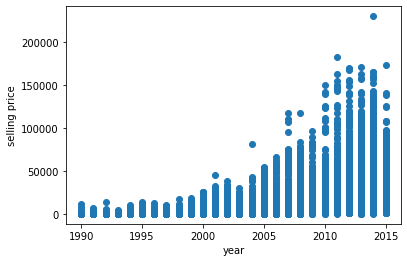

In [30]:
plt.scatter(data_cars['year'], data_cars['sellingprice'])
plt.ylabel("selling price")
plt.xlabel("year")
plt.show()

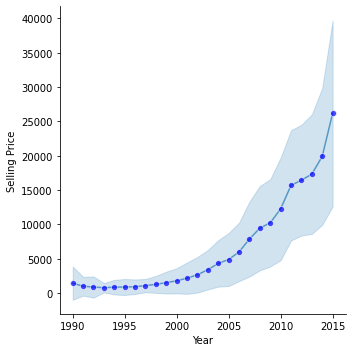

In [31]:
sns.relplot(
    x="year",
    y="sellingprice",
    kind="line",
    data=data_cars,
    marker="o",
    alpha=0.7,
    markerfacecolor="blue",
    errorbar='sd'
)

plt.xlabel("Year")
plt.ylabel("Selling Price")
plt.show()

There is a positive correlation between manufacturing year and selling price. More recently manufactured vehicles tend to be sold for a higher price.

The above table shows an overall trend of increasing mean selling price with increasing vehicle condition. A better vehicle condition goes along with a higher selling price.

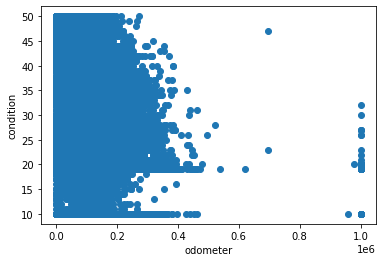

In [32]:
plt.scatter(data_cars['odometer'], data_cars['condition'])
plt.ylabel("condition")
plt.xlabel("odometer")
plt.show()

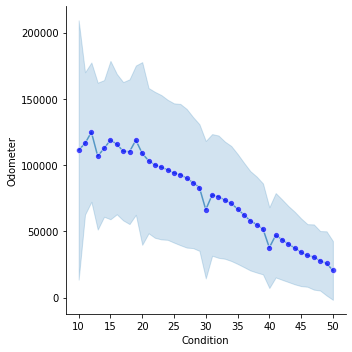

In [33]:
sns.relplot(
    x="condition",
    y="odometer",
    kind="line",
    data=data_cars,
    marker="o",
    alpha=0.7,
    markerfacecolor="blue",
    errorbar='sd'
)

plt.ylabel("Odometer")
plt.xlabel("Condition")
plt.show()

We can see some kind of relationship between odometer and condition, with high condition vehicles having less mileage than lower condition vehicles. To further analyse the relationship we will condct a correlation analysis later on. 

In [34]:
data_cars.groupby('condition')['odometer'].describe()

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
10.0,5805.0,111453.690784,97844.603501,1.0,34547.00,108749.0,161444.00,999999.0
11.0,79.0,116367.544304,53724.846853,1.0,80034.00,118718.0,158077.00,266028.0
12.0,86.0,124923.232558,52575.787261,1.0,97809.00,126183.5,154553.00,266953.0
13.0,74.0,106801.972973,55456.031475,1.0,74305.75,113867.5,138466.25,321887.0
14.0,116.0,112630.137931,51576.122336,1.0,89613.25,117745.5,143321.00,223102.0
15.0,116.0,118938.560345,59786.753831,1.0,82537.75,118921.0,147433.00,353583.0
16.0,151.0,115894.966887,52999.706235,1.0,82603.50,115886.0,148794.00,392570.0
17.0,209.0,110510.985646,52196.024215,1.0,77954.00,112867.0,145124.00,276028.0
18.0,290.0,110164.065517,54633.068115,1.0,75677.50,108689.5,142682.50,296231.0


While the mean odometer (mileage) value is quite similar for vehicles in the condition rating range 10-20, we can observe an overall decrease in mean odometer value with increasing condition rating between 20 and 50. A lower the mileage goes along with a higher condition rating.

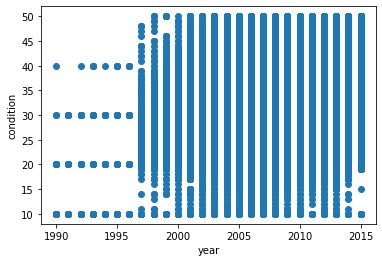

In [35]:
plt.scatter(data_cars['year'], data_cars['condition'])
plt.ylabel("condition")
plt.xlabel("year")
plt.show()

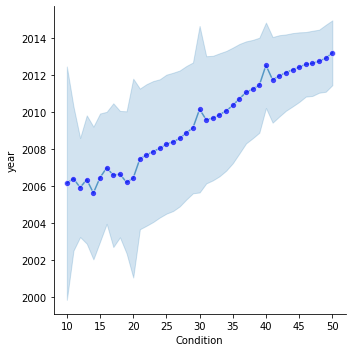

In [36]:
sns.relplot(
    x="condition",
    y="year",
    kind="line",
    data=data_cars,
    marker="o",
    alpha=0.7,
    markerfacecolor="blue",
    errorbar='sd'
)

plt.ylabel("year")
plt.xlabel("Condition")
plt.show()

The scatter plot displaying the relationship between the manufacturing year and the vehicle condition shows, that vehicles with a manufacturing year <= 1996 are only rated in decimal steps. Remembering our earlier condition rescaling of the 1-5 rating system, we can deduce that this rating system had been used for these vehicles. Analysing the relationship between the year of sale and the condition could give us further insight at which point the rating system has been changed.

Overall we can see on the plot that regardless of the manufacturing year, there are vehicles from almost every year in all conditions.

In [37]:
data_cars.groupby('condition')['year'].describe()

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
10.0,5805.0,2006.154866,6.322781,1990.0,2002.0,2006.0,2013.00,2015.0
11.0,79.0,2006.405063,3.904366,1997.0,2004.0,2006.0,2009.00,2014.0
12.0,86.0,2005.918605,2.684225,2000.0,2004.0,2006.0,2007.00,2013.0
13.0,74.0,2006.351351,3.477649,1998.0,2004.0,2007.0,2008.00,2014.0
14.0,116.0,2005.620690,3.596267,1997.0,2003.0,2006.0,2008.00,2014.0
15.0,116.0,2006.456897,3.472606,1999.0,2004.0,2006.0,2008.25,2015.0
16.0,151.0,2006.986755,3.035318,1998.0,2005.0,2007.0,2009.00,2014.0
17.0,209.0,2006.588517,3.894407,1997.0,2004.0,2007.0,2009.00,2014.0
18.0,290.0,2006.644828,3.425135,1997.0,2004.0,2007.0,2009.00,2014.0


A higher condition rating goes along with a more recent manufacturing year in vehicles.

In [38]:
data_cars.groupby('body', as_index=False).agg(n_matches=('sellingprice', 'mean')).sort_values('n_matches', ascending=False).head(5)

,body,n_matches
23,granturismo convertible,75090.909091
12,cts-v wagon,50500.000000
11,cts-v coupe,38073.884615
30,q60 convertible,36636.250000
27,mega cab,30220.103093


The vehicle body type 'granturismo convertible' has brought in the highest mean selling price of 75090.90.

In [39]:
data_cars.groupby('body', as_index=False).agg(n_matches=('sellingprice', 'mean')).sort_values('n_matches', ascending=False).tail(5)

,body,n_matches
25,king cab,9395.964126
44,xtracab,5713.235294
4,club cab,5028.733333
2,cab plus,3266.666667
33,ram van,1200.000000


The vehicle body type 'ram van' has brought in the lowest mean selling price of 1200.00.

In [40]:
data_cars['color'].value_counts()

color
black        93244
white        89233
silver       71251
gray         70640
blue         43060
red          37336
—            22068
gold          9563
green         9234
burgundy      7605
beige         7444
brown         5621
orange        1763
purple        1270
off-white     1244
yellow        1079
charcoal       429
turquoise      190
pink            39
lime            12
Name: count, dtype: int64

In [41]:
data_cars.groupby('color', as_index=False).agg(n_matches=('sellingprice', 'mean')).sort_values('n_matches', ascending=False).head(5)

,color,n_matches
19,—,17824.400218
5,charcoal,16256.062937
3,brown,15531.780288
1,black,15474.098430
10,off-white,15374.599678


Vehicles with no specified color have brought in the highest mean selling price of 17824.40.
Of the specified colors, 'charcoal' brings in the highest mean selling price of 16256.06 with only 429 vehicles in the dataset.

In [42]:
data_cars.groupby('color', as_index=False).agg(n_matches=('sellingprice', 'mean')).sort_values('n_matches', ascending=False).tail(5)

,color,n_matches
2,blue,11549.820111
0,beige,9523.642262
16,turquoise,8816.326316
8,green,8800.623890
6,gold,8621.803514


Vehicles with the color gold have brought in the lowest mean selling price of 8621.80.

### Pearson Correlation calculation for continuous values
Pearson correlation coefficient assesses the linear relationship between variables.


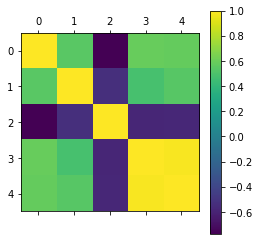

,year,condition,odometer,mmr,sellingprice
year,1.00,0.55,-0.77,0.59,0.58
condition,0.55,1.00,-0.54,0.48,0.54
odometer,-0.77,-0.54,1.00,-0.58,-0.58
mmr,0.59,0.48,-0.58,1.00,0.98
sellingprice,0.58,0.54,-0.58,0.98,1.00


In [43]:
#plt.matshow(data_cars.corr(numeric_only = True))
plt.matshow(data_cars[['year', 'condition', 'odometer', 'mmr', 'sellingprice']].corr(method='pearson'))
plt.colorbar()
plt.show()

np.set_printoptions(precision=1)
corrs = data_cars[['year', 'condition', 'odometer', 'mmr', 'sellingprice']].select_dtypes(exclude=['object']).corr(method="pearson").round(2)
corrs


Strongest correlation between market value of vehicles and selling price (mmr - sellingprice --> 0.98)
Very strong, positive correlation. The higher the selling price, the higher the market value

Strong negative correlation between manufacturing year and mileage (year - odometer --> -0.77)
The earlier the manufacturing year, the higher the mileage

Moderate positive correlations between manufacturing year and price/ market value (year - mmr --> 0.59 & year - sellingprice --> 0.58)
The later the manufacturing year, the higher the price/ market value

Moderate negative correlation between mileage and price/ market value (odometer - mmr --> -0.58 & odometer - sellingprice --> -0.58)
The higher the mileage, the lower the price/ market value

Moderate positive correlation between manufacturing year and vehicle condition (year - condition --> 0.55)

Moderate negative correlation between odometer and vehicle condition (condition - odometer --> -0.54)

Moderate positive correlation between price and vehicle condition (condition - sellingprice --> 0.54)

Low positive correlation between market value and vehicle condition (condition - mmr --> 0.48)


In [44]:
from itertools import combinations


combinations = list(combinations(['year', 'condition', 'odometer', 'mmr', 'sellingprice'], 2))
for c in combinations:
    r, p = stats.pearsonr(data_cars[c[0]], data_cars[c[1]])
    if p < 0.05:
        print(f'Correlation between {c[0]} and {c[1]} is significant')
    else:
        print(f'Correlation between {c[0]} and {c[1]} is not significant')

Correlation between year and condition is significant
Correlation between year and odometer is significant
Correlation between year and mmr is significant
Correlation between year and sellingprice is significant
Correlation between condition and odometer is significant
Correlation between condition and mmr is significant
Correlation between condition and sellingprice is significant
Correlation between odometer and mmr is significant
Correlation between odometer and sellingprice is significant
Correlation between mmr and sellingprice is significant


All calculated Pearson correlations are statistically significant (p < 0.05)

### Spearman Correlation calculation for continuous values
The Spearman correlation coefficient evaluates the monotonic relationship.


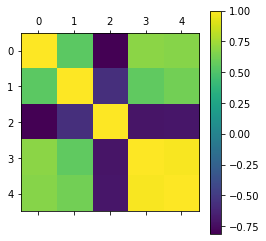

,year,condition,odometer,mmr,sellingprice
year,1.00,0.54,-0.81,0.68,0.67
condition,0.54,1.00,-0.57,0.55,0.61
odometer,-0.81,-0.57,1.00,-0.71,-0.70
mmr,0.68,0.55,-0.71,1.00,0.98
sellingprice,0.67,0.61,-0.70,0.98,1.00


In [45]:
#plt.matshow(data_cars.corr(numeric_only = True))
plt.matshow(data_cars[['year', 'condition', 'odometer', 'mmr', 'sellingprice']].corr(method='spearman'))
plt.colorbar()
plt.show()

np.set_printoptions(precision=1)
corrs = data_cars[['year', 'condition', 'odometer', 'mmr', 'sellingprice']].select_dtypes(exclude=['object']).corr(method="spearman").round(2)
corrs


Strongest correlation between market value of vehicles and selling price (mmr - sellingprice --> 0.98)
Very strong, positive correlation. The higher the selling price, the higher the market value

Strong negative correlation between manufacturing year and mileage (year - odometer --> -0.81)
The earlier the manufacturing year, the higher the mileage

Strong negative correlation between mileage and price/ market value (odometer - mmr --> -0.71 & odometer - sellingprice --> -0.70)
The higher the mileage, the lower the price/ market value

Moderate positive correlations between manufacturing year and price/ market value (year - mmr --> 0.68  & year - sellingprice --> 0.67)
The later the manufacturing year, the higher the price/ market value

Moderate positive correlation between price and vehicle condition (condition - sellingprice --> 0.61)

Moderate negative correlation between odometer and vehicle condition (condition - odometer --> -0.57)

Moderate positive correlation between market value and vehicle condition (condition - mmr --> 0.55)

Moderate positive correlation between manufacturing year and vehicle condition (year - condition --> 0.54)



#### The Spearman correlation coefficients are higher than the pearson correlation coefficients, indicating a more monotonic than linear relationship between variables.

In [46]:
from itertools import combinations


combinations = list(combinations(['year', 'condition', 'odometer', 'mmr', 'sellingprice'], 2))
for c in combinations:
    r, p = stats.spearmanr(data_cars[c[0]], data_cars[c[1]])
    if p < 0.05:
        print(f'Correlation between {c[0]} and {c[1]} is significant')
    else:
        print(f'Correlation between {c[0]} and {c[1]} is not significant')

Correlation between year and condition is significant
Correlation between year and odometer is significant
Correlation between year and mmr is significant
Correlation between year and sellingprice is significant
Correlation between condition and odometer is significant
Correlation between condition and mmr is significant
Correlation between condition and sellingprice is significant
Correlation between odometer and mmr is significant
Correlation between odometer and sellingprice is significant
Correlation between mmr and sellingprice is significant


All calculated Spearman correlations are statistically significant (p < 0.05)

### Cramer's V - Associations between nominal categorical attributes

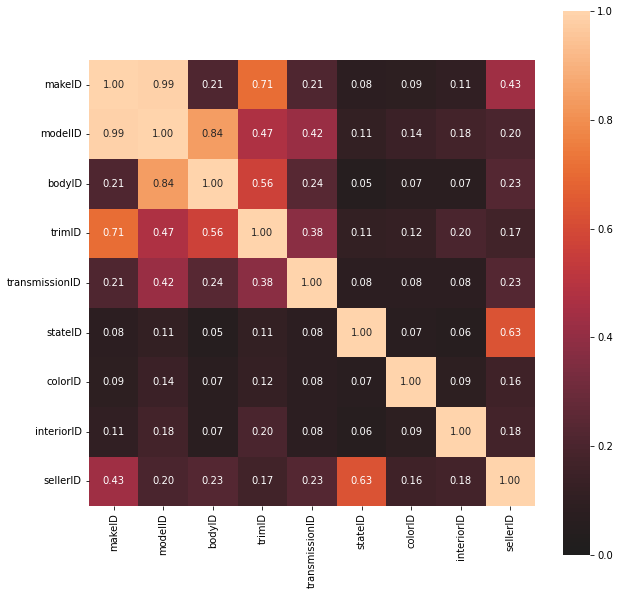

In [47]:
nominal_attrs = ['makeID', 'modelID', 'bodyID', 'trimID', 'transmissionID', 'stateID', 'colorID', 'interiorID', 'sellerID']

for el in nominal_attrs:
    data_cars[el] = data_cars[el].astype("category")

complete_correlation= associations(data_cars[nominal_attrs], figsize=(10,10), cmap=None)

Cramer's V between nominal categorical attributes shows a higher association between two attributes with a higher value.

high associations:
- modelID - makeID <-- 0.99
- trimID - makeID <-- 0.71
- bodyID - modelID <-- 0.84
- sellerID - stateID <-- 0.63


moderate associations:
- makeID - sellerID <-- 0.43
- trimID - modelID <-- 0.47
- modelID - transmissionID <-- 0.42
- trimID - bodyID <-- 0.56
- trimID - transmissionID <-- 0.38

In [48]:
data_cars.groupby(by=['make'])['transmission'].describe().head(10)

,count,unique,top,freq
make,,,,
acura,4503,2,automatic,4340
aston martin,24,2,automatic,19
audi,4802,2,automatic,4459
bentley,105,1,automatic,105
bmw,17509,2,automatic,16697
buick,4470,2,automatic,4460
cadillac,6315,2,automatic,6269
chevrolet,54150,2,automatic,52879
chrysler,15133,2,automatic,15052


Out of the shown 10 vehicle manufacturers, automatic cars are the most popular among sales.

### Plot Distribution of vehicle types

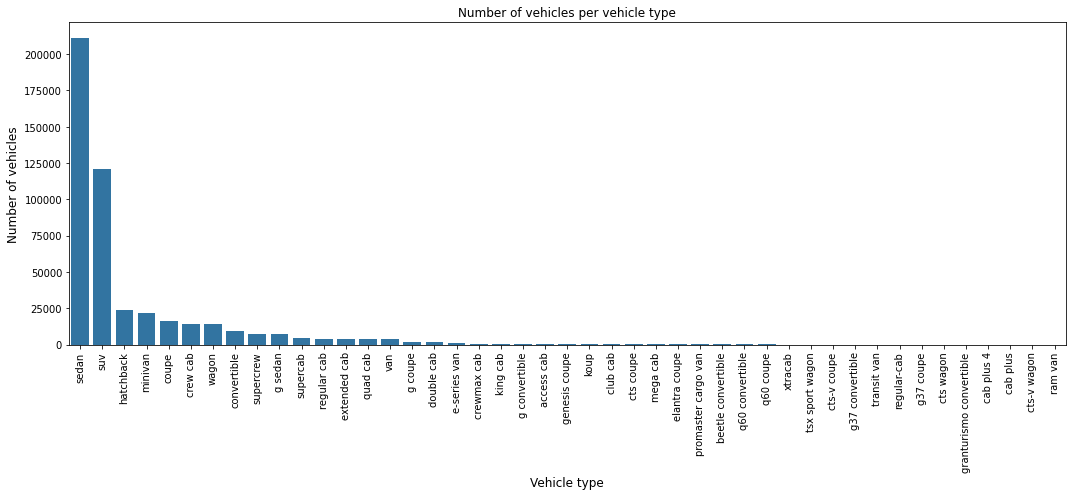

In [49]:
fig, axes = plt.subplots(1,1, figsize=(15,7))

sns.countplot(x=data_cars['body'], order = data_cars['body'].value_counts().index, ax=axes);
plt.xticks(rotation=90);
plt.title('Count of each body type');

axes.set_xticks(axes.get_xticks())
axes.set_xticklabels(axes.get_xticklabels())
axes.tick_params(axis='x', labelrotation = 90)
axes.set_ylabel('Number of vehicles', fontsize=12)
axes.set_xlabel('Vehicle type', fontsize=12)
#axes.bar_label(axes.containers[0], fontsize=10, rotation = 90)
axes.set_title('Number of vehicles per vehicle type', fontsize=12)

plt.tight_layout()
plt.show()

Most vehicles in the dataset belong to the vehicle type 'Sedan', with the vehicle type 'SUV' being the second highest type frequency.
The vehicle types 'Ram van' and and 'cts-v wagon' are the rarest vehicle types in the dataset.

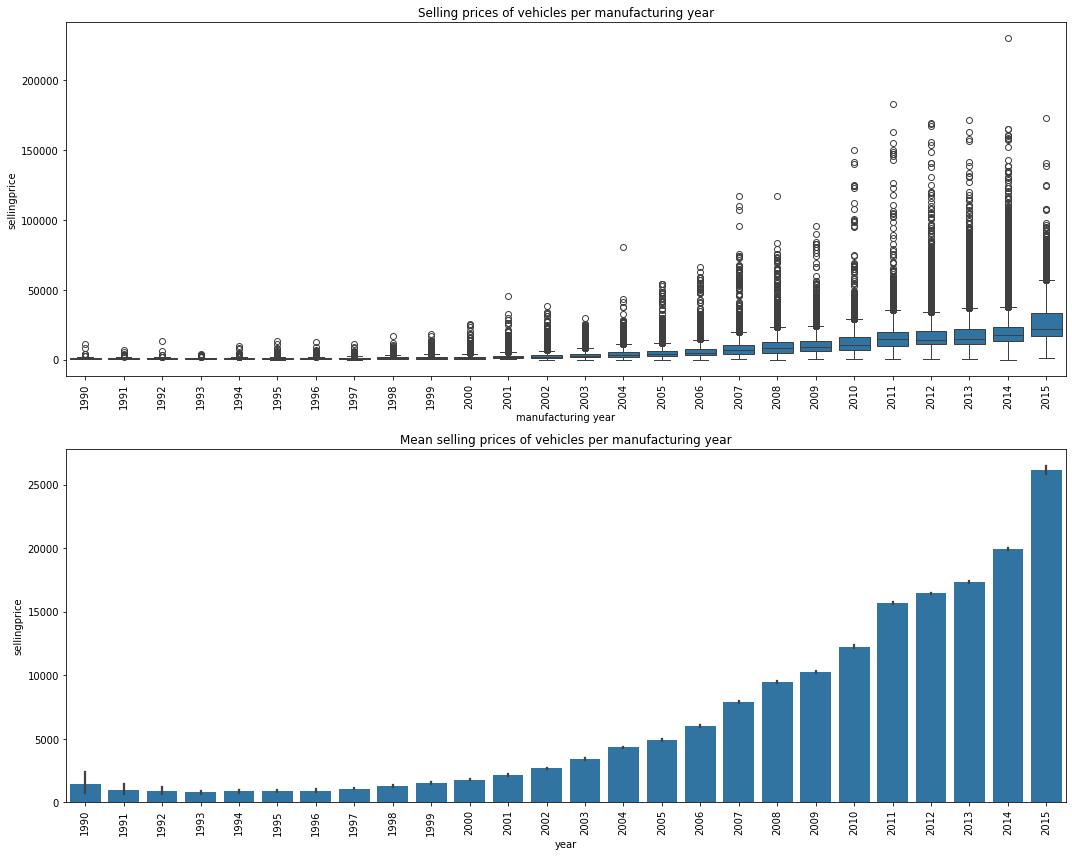

In [50]:
fig, axes = plt.subplots(2,1, figsize=(15, 12))


sns.boxplot(x=data_cars['year'], y=data_cars['sellingprice'], showfliers=True, ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels())
axes[0].tick_params(axis='x', labelrotation = 90)
axes[0].set_xlabel('manufacturing year')
axes[0].set_title('Selling prices of vehicles per manufacturing year', fontsize=12)


grouped_mean = data_cars.loc[:,['year', 'sellingprice']] \
    .groupby(['year']) \
    .mean() \
    .sort_values(by='sellingprice')

sns.barplot(x=data_cars['year'], y=data_cars['sellingprice'], estimator='mean', ax = axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels())
axes[1].tick_params(axis='x', labelrotation = 90)
axes[1].set_title('Mean selling prices of vehicles per manufacturing year', fontsize=12)


plt.tight_layout()
plt.show()

The more recent the manufacturing year of a car, the higher the mean selling price

In [51]:
df1 = data_cars.groupby(['year','make']).agg({'sellingprice': 'mean'})
idx = df1.groupby(['year'])['sellingprice'].idxmax()
max_scores = df1.loc[idx]
max_scores

,,sellingprice
year,make,
1990,chevrolet,6020.000000
1991,bmw,6750.000000
1992,chevrolet,3743.750000
1993,gmc,1600.000000
1994,chevrolet,2993.750000
1995,mercedes-benz,2309.615385
1996,lexus,2080.769231
1997,porsche,5866.666667
1998,porsche,6633.333333


The table above shows the manufacturer with the highest mean selling price per manufacturing year of the sold vehicles. Of all vehicles manufactured in 2015, vehicles by the manufacturer 'Jaguar' achieved the highest mean selling price of 75706.66 

In [52]:
df1 = data_cars.groupby(['year','make']).agg({'make': 'count'})#['make'].count()
idx = df1.groupby(['year'])['make'].idxmax()
max_scores = df1.loc[idx]
max_scores

,,make
year,make,
1990,honda,7
1991,toyota,13
1992,toyota,21
1993,toyota,33
1994,honda,63
1995,toyota,73
1996,toyota,96
1997,honda,182
1998,honda,253


The table above shows the manufacturer with the highest number of sales of vehicles from each manufacturing year. Looking at all vehicles in the dataset that have been manufactured in 2015, vehicles by manufacturer 'Chevrolet' were sold the most (1256 vehicles). 

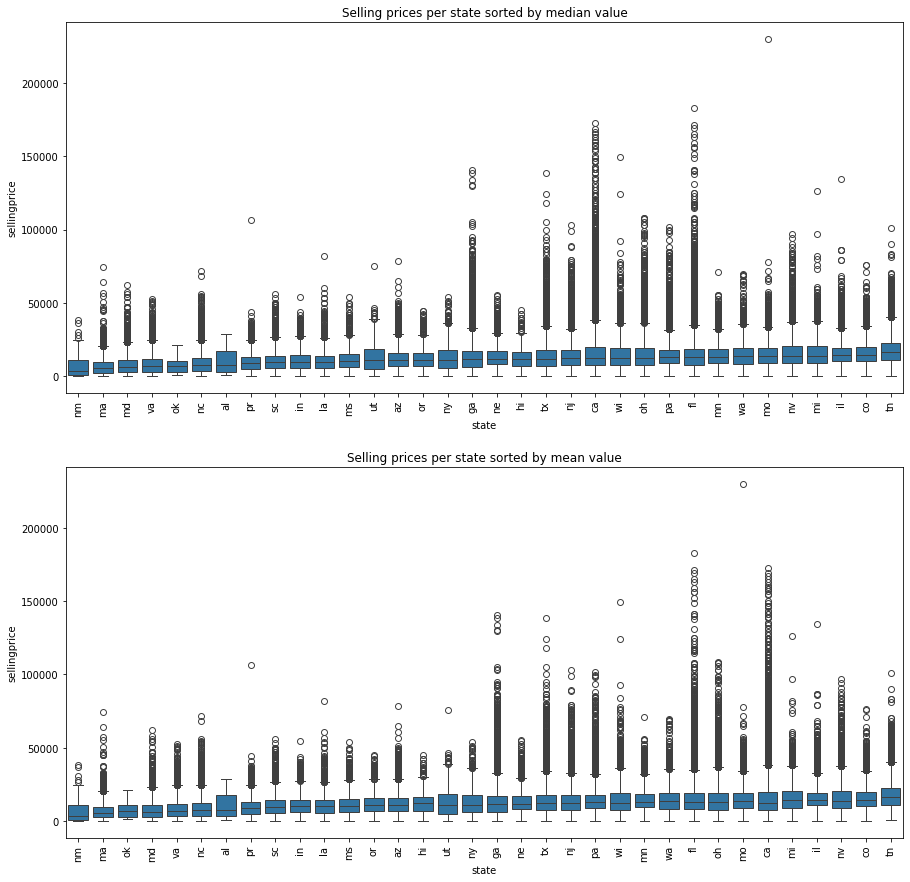

In [53]:
fig, axes = plt.subplots(2,1, figsize=(15, 15))

grouped_median = data_cars.loc[:,['state', 'sellingprice']] \
    .groupby(['state']) \
    .median() \
    .sort_values(by='sellingprice')

sns.boxplot(x=data_cars['state'], y=data_cars['sellingprice'], order=grouped_median.index, showfliers=True, ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels())
axes[0].tick_params(axis='x', labelrotation = 90)


grouped_mean = data_cars.loc[:,['state', 'sellingprice']] \
    .groupby(['state']) \
    .mean() \
    .sort_values(by='sellingprice')

sns.boxplot(x=data_cars['state'], y=data_cars['sellingprice'], order=grouped_mean.index, showfliers=True, ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels())
axes[1].tick_params(axis='x', labelrotation = 90)


axes[0].set_title('Selling prices per state sorted by median value', fontsize=12); 
axes[1].set_title('Selling prices per state sorted by mean value', fontsize=12)

plt.show()

Tennessee (tn) has the highest mean and median selling price per vehicle while New Mexico (nm) has the lowest mean and median selling price per vehicle.

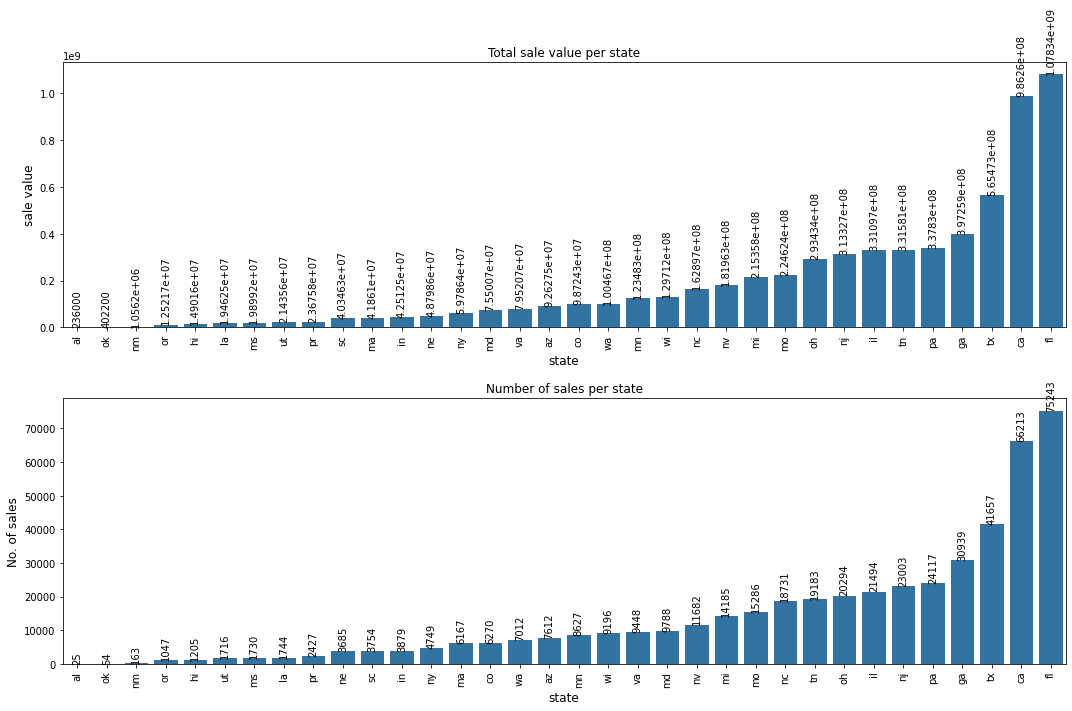

In [54]:
fig, axes = plt.subplots(2,1, figsize=(15,10))


grouped_sum = data_cars.loc[:,['state', 'sellingprice']] \
    .groupby(['state']) \
    .sum() \
    .sort_values(by='sellingprice')


sns.barplot(x=grouped_sum.index, y='sellingprice', data=grouped_sum, order=grouped_sum.index, ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels())
axes[0].tick_params(axis='x', labelrotation = 90)
axes[0].set_ylabel('sale value', fontsize=12)
axes[0].set_xlabel('state', fontsize=12)
axes[0].bar_label(axes[0].containers[0], fontsize=10, rotation = 90)
axes[0].set_title('Total sale value per state', fontsize=12)


grouped_count = data_cars.groupby(['state']).count().sort_values(by='year')

sns.barplot(x=grouped_count.index, y='year', data=grouped_count, order=grouped_count.index, ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels())
axes[1].tick_params(axis='x', labelrotation = 90)
axes[1].set_ylabel('No. of sales', fontsize=12)
axes[1].set_xlabel('state', fontsize=12)
axes[1].bar_label(axes[1].containers[0], fontsize=10, rotation = 90);
axes[1].set_title('Number of sales per state', fontsize=12)
plt.tight_layout()
plt.show()




Florida has the highest total sale value and the highest number of sales, while the lowest total sale value and lowest number of sales have been achieved in Alabama.



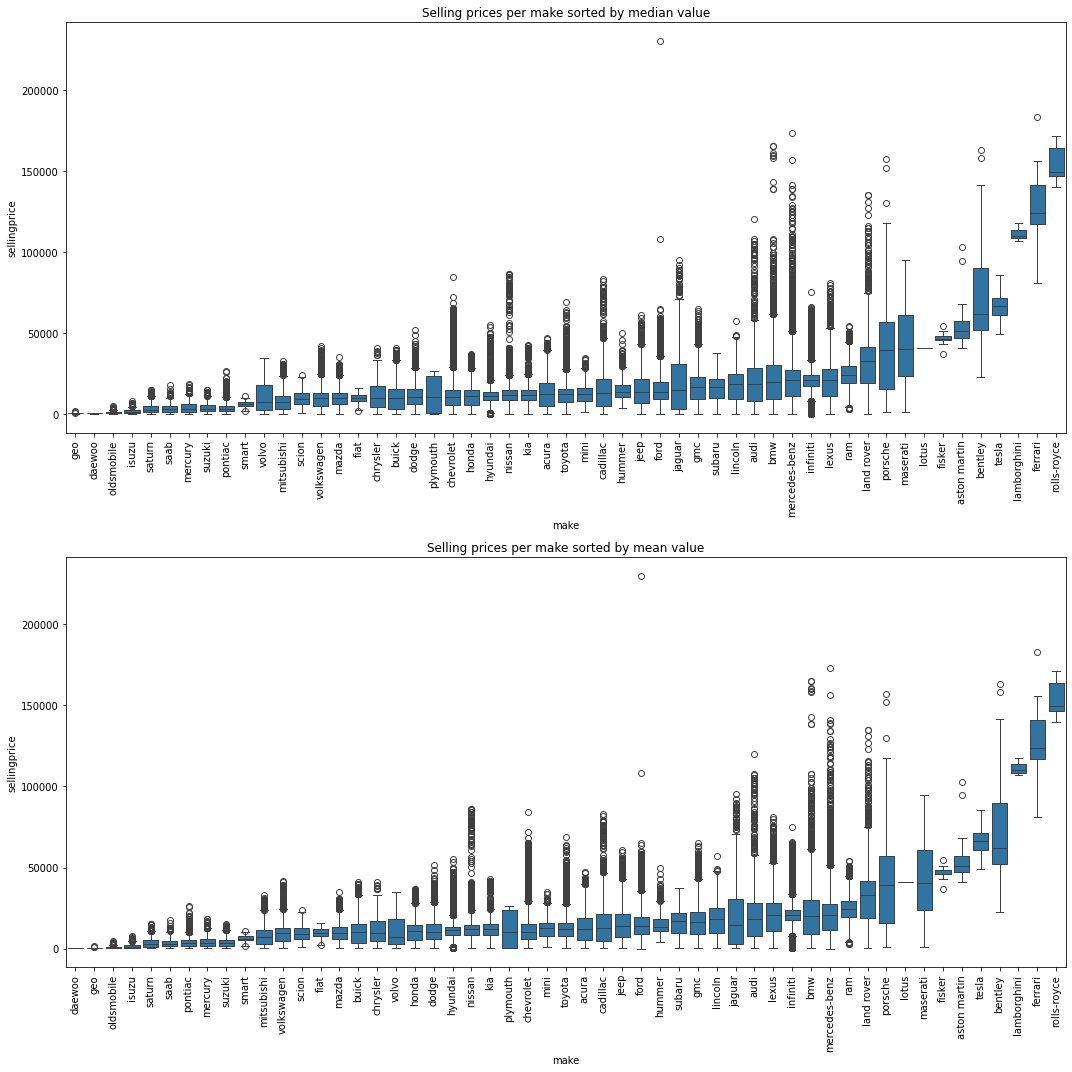

In [55]:
fig, axes = plt.subplots(2,1, figsize=(15, 15))

grouped_median = data_cars.loc[:,['make', 'sellingprice']] \
    .groupby(['make']) \
    .median() \
    .sort_values(by='sellingprice')

sns.boxplot(x=data_cars['make'], y=data_cars['sellingprice'], order=grouped_median.index, showfliers=True, ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels())
axes[0].tick_params(axis='x', labelrotation = 90)

grouped_mean = data_cars.loc[:,['make', 'sellingprice']] \
    .groupby(['make']) \
    .mean() \
    .sort_values(by='sellingprice')

sns.boxplot(x=data_cars['make'], y=data_cars['sellingprice'], order=grouped_mean.index, showfliers=True, ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels())
axes[1].tick_params(axis='x', labelrotation = 90)

axes[0].set_title('Selling prices per make sorted by median value', fontsize=12)
axes[1].set_title('Selling prices per make sorted by mean value', fontsize=12)
plt.tight_layout()
plt.show()

Rolls Royce vehicles have been sold for the highest mean and median prices.
Vehicles by the manufacturer Geo have been sold for the lowest median price, while vehicles by the manufacturer Daewoo have been sold for the lowest mean price.

The highest single selling price has been achieved by a Ford vehicle.

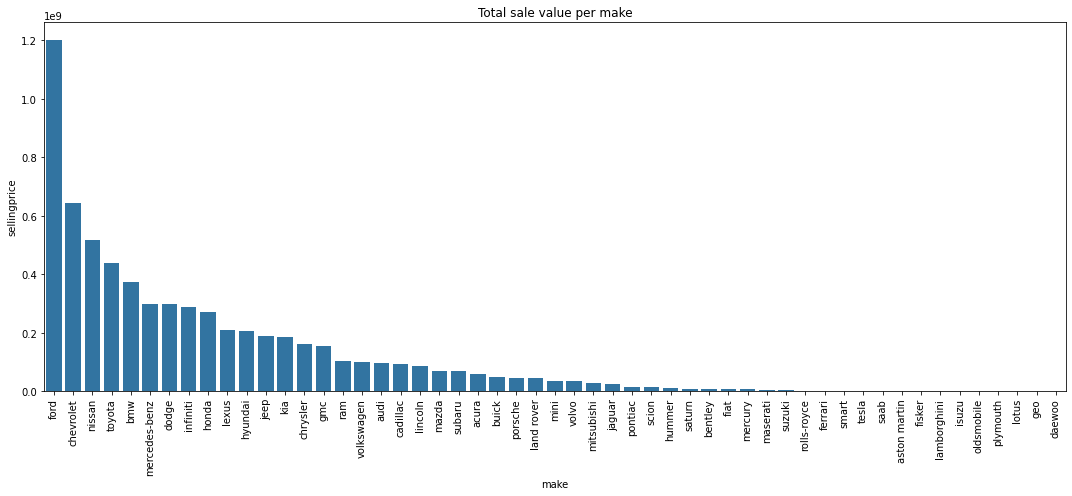

In [56]:
bla = data_cars.groupby(['make'])['sellingprice'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1,1, figsize=(15, 7))

sns.barplot(x=bla.index, y=bla, ax=axes)
axes.set_xticks(axes.get_xticks())
axes.set_xticklabels(axes.get_xticklabels())
axes.tick_params(axis='x', labelrotation = 90)

axes.set_title('Total sale value per make', fontsize=12)

plt.tight_layout()
plt.show()

Vehicles by manufacturer 'Ford' have brought in the highest total sale value, while vehicles by manufacturer 'Daewoo' have brought in the lowest.

### Sales per Seller
Due to the large number of sellers only the top 30 sellers with the most sales are pictured in the plot

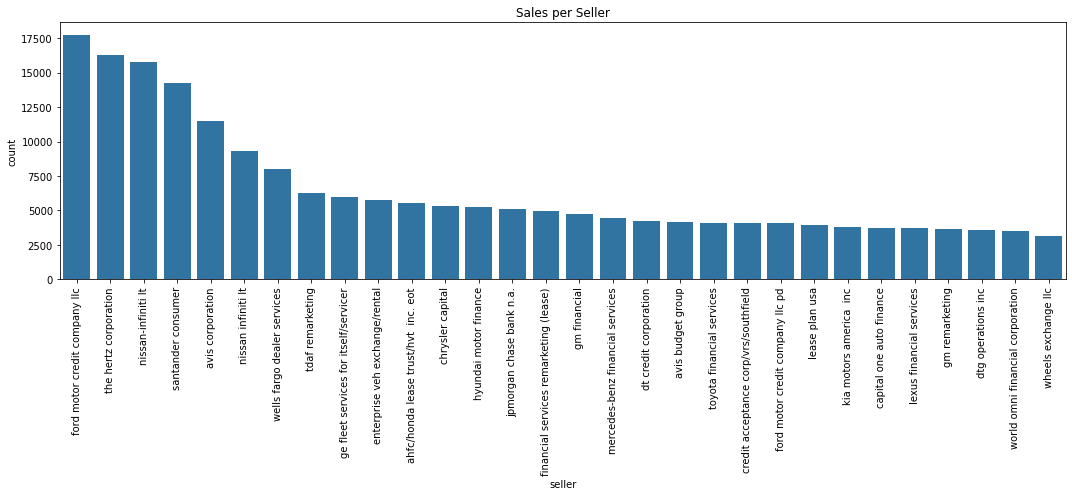

In [57]:
fig, axes = plt.subplots(1,1, figsize=(15, 7))
sns.barplot(x = data_cars['seller'].value_counts().index[0:30], y=data_cars['seller'].value_counts()[0:30], ax=axes)
axes.set_xticks(axes.get_xticks())
axes.set_xticklabels(axes.get_xticklabels())
axes.tick_params(axis='x', labelrotation = 90)
axes.set_title('Sales per Seller', fontsize=12)

plt.tight_layout()
plt.show()

The seller with the highest number of sales is the 'Ford Motor Credit Company LLC'. 

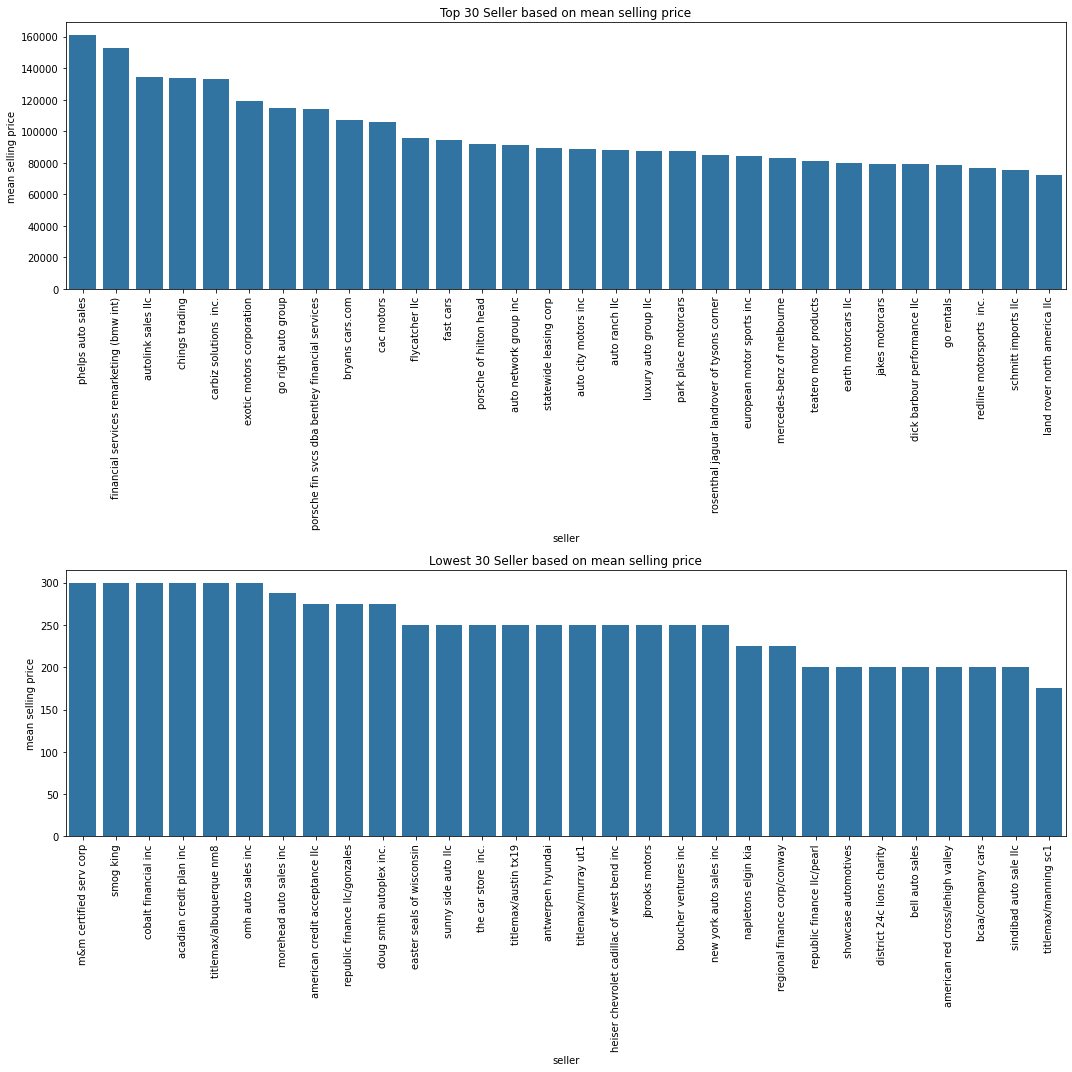

In [58]:
grouped_mean = data_cars.loc[:,['seller', 'sellingprice']] \
    .groupby(['seller']) \
    .mean() \
    .sort_values(by='sellingprice', ascending=False)

#print(grouped_mean['sellingprice'])

fig, axes = plt.subplots(2,1, figsize=(15, 15))

sns.barplot(x = grouped_mean.index[0:30], y=grouped_mean['sellingprice'][0:30], ax=axes[0]) # order=list(grouped_mean.index), 
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels())
axes[0].set_ylabel("mean selling price")
axes[0].tick_params(axis='x', labelrotation = 90)
axes[0].set_title('Top 30 Seller based on mean selling price', fontsize=12)

sns.barplot(x = grouped_mean.index[len(grouped_mean.index)-30:], y=grouped_mean['sellingprice'][len(grouped_mean.index)-30:], ax=axes[1]) # order=list(grouped_mean.index), 
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels())
axes[1].set_ylabel("mean selling price")
axes[1].tick_params(axis='x', labelrotation = 90)
axes[1].set_title('Lowest 30 Seller based on mean selling price', fontsize=12)

plt.tight_layout()
plt.show()

Sellers with the highest and lowest mean selling prices.

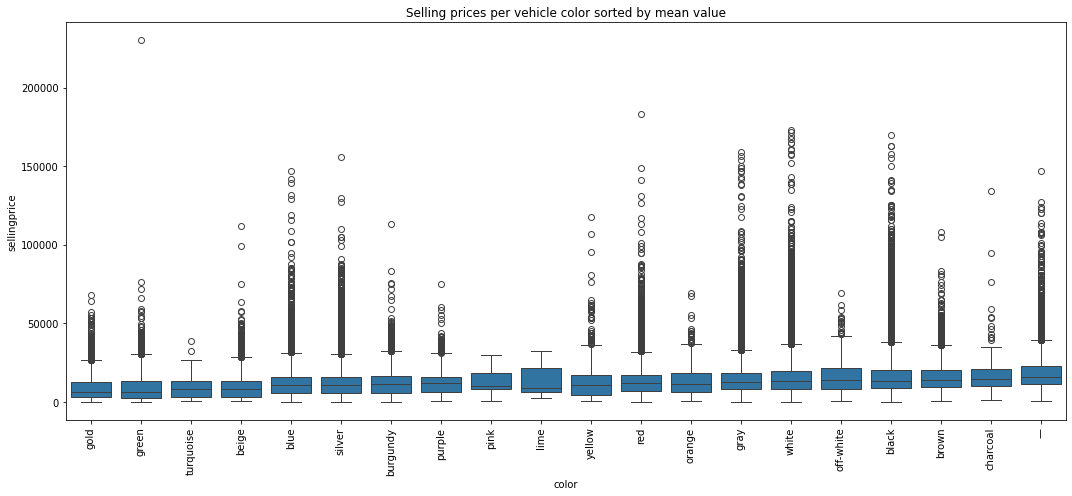

In [59]:
fig, axes = plt.subplots(1,1, figsize=(15, 7))

grouped_mean = data_cars.loc[:,['color', 'sellingprice']] \
    .groupby(['color']) \
    .mean() \
    .sort_values(by='sellingprice')

sns.boxplot(x=data_cars['color'], y=data_cars['sellingprice'], order=grouped_mean.index, showfliers=True, ax=axes)
axes.set_xticks(axes.get_xticks())
axes.set_xticklabels(axes.get_xticklabels())
axes.tick_params(axis='x', labelrotation = 90)

axes.set_title('Selling prices per vehicle color sorted by mean value', fontsize=12)
plt.tight_layout()
plt.show()

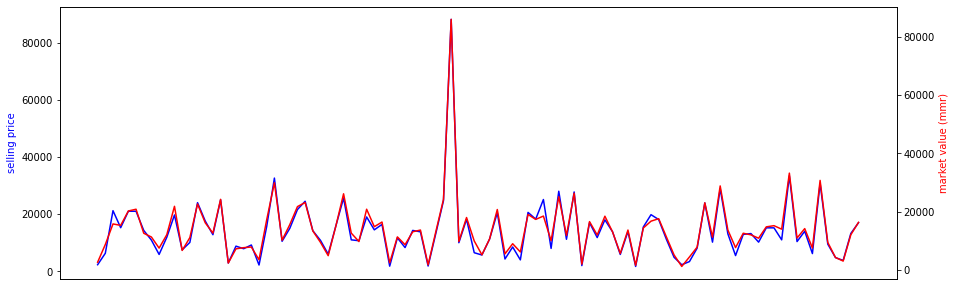

R2 score = 0.9812265438931531


In [60]:
random_vehicle_sales = data_cars.sample(n=100)

fig, ax1 = plt.subplots(figsize=(15,5))

ax2 = ax1.twinx()
ax1.plot(range(len(random_vehicle_sales)), random_vehicle_sales['sellingprice'], color='blue', label="selling price")
ax2.plot(range(len(random_vehicle_sales)), random_vehicle_sales['mmr'], color='red', label="market value")

ax1.set_ylabel('selling price', color='blue')
ax2.set_ylabel('market value (mmr)', color='red')

plt.xlabel('random vehicles')
plt.xticks([])
plt.show()

print(f"R2 score = {r2_score(random_vehicle_sales['sellingprice'], random_vehicle_sales['mmr'])}")

Market Value compared to actual selling price:
Selling price and market value of vehicles are in most cases very close to each other

### Sale numbers grouped by month and week
we can see that the underlying data does not seamlessly cover the whole timeframe of data collection. There are multiple months respectively weeks missing in 2014 and multiple other months/ weeks show such high deviations regarding the number of sales that it is questionable if the dataset contains the complete records for these months.

C:\Users\Nadine\AppData\Local\Temp\ipykernel_17916\2957913737.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_time_base = data_cars['sellingprice'].groupby(data_cars['saledate'].dt.to_period('M'))


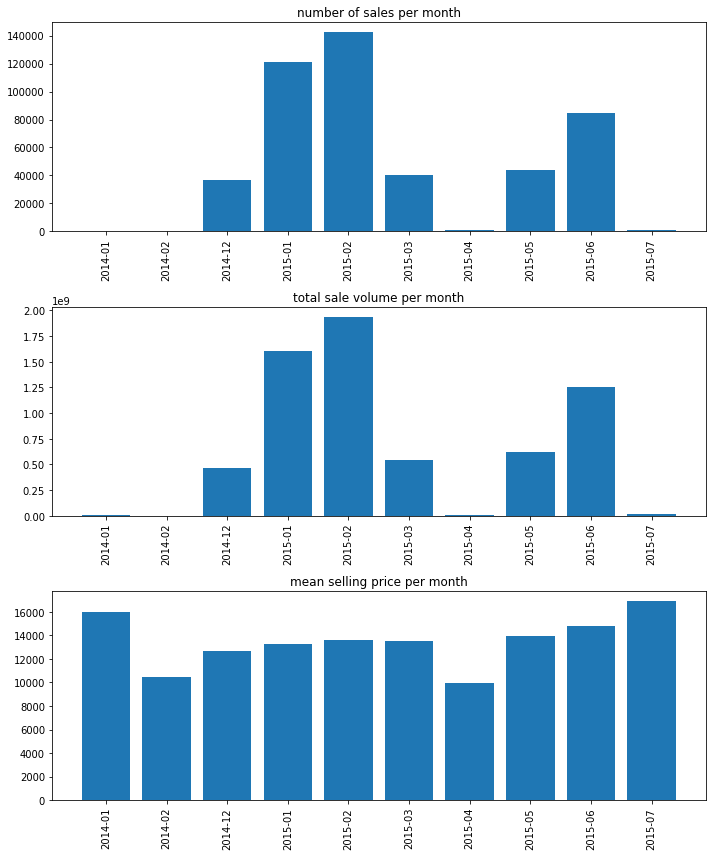

In [61]:
fig, ax = plt.subplots(3,1, figsize=(10,12))

data_time_base = data_cars['sellingprice'].groupby(data_cars['saledate'].dt.to_period('M'))

data_time = data_time_base.count()

bars = ax[0].bar(data_time.index.to_series().astype(str), data_time)
#ax[0].bar_label(bars, rotation = 90)
ax[0].tick_params(axis='x', labelrotation = 90)
ax[0].set_title('number of sales per month', fontsize=12)


data_time = data_time_base.sum()

bars = ax[1].bar(data_time.index.to_series().astype(str), data_time)
#ax[0].bar_label(bars, rotation = 90, label_type='center')
ax[1].tick_params(axis='x', labelrotation = 90)
ax[1].set_title('total sale volume per month', fontsize=12)



data_time = data_time_base.mean()

bars = ax[2].bar(data_time.index.to_series().astype(str), data_time)
#ax[1].bar_label(bars, rotation = 90, label_type='center')
ax[2].tick_params(axis='x', labelrotation = 90)
ax[2].set_title('mean selling price per month', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\Nadine\AppData\Local\Temp\ipykernel_17916\1447648129.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_time_base = data_cars['sellingprice'].groupby(data_cars['saledate'].dt.to_period('w'))


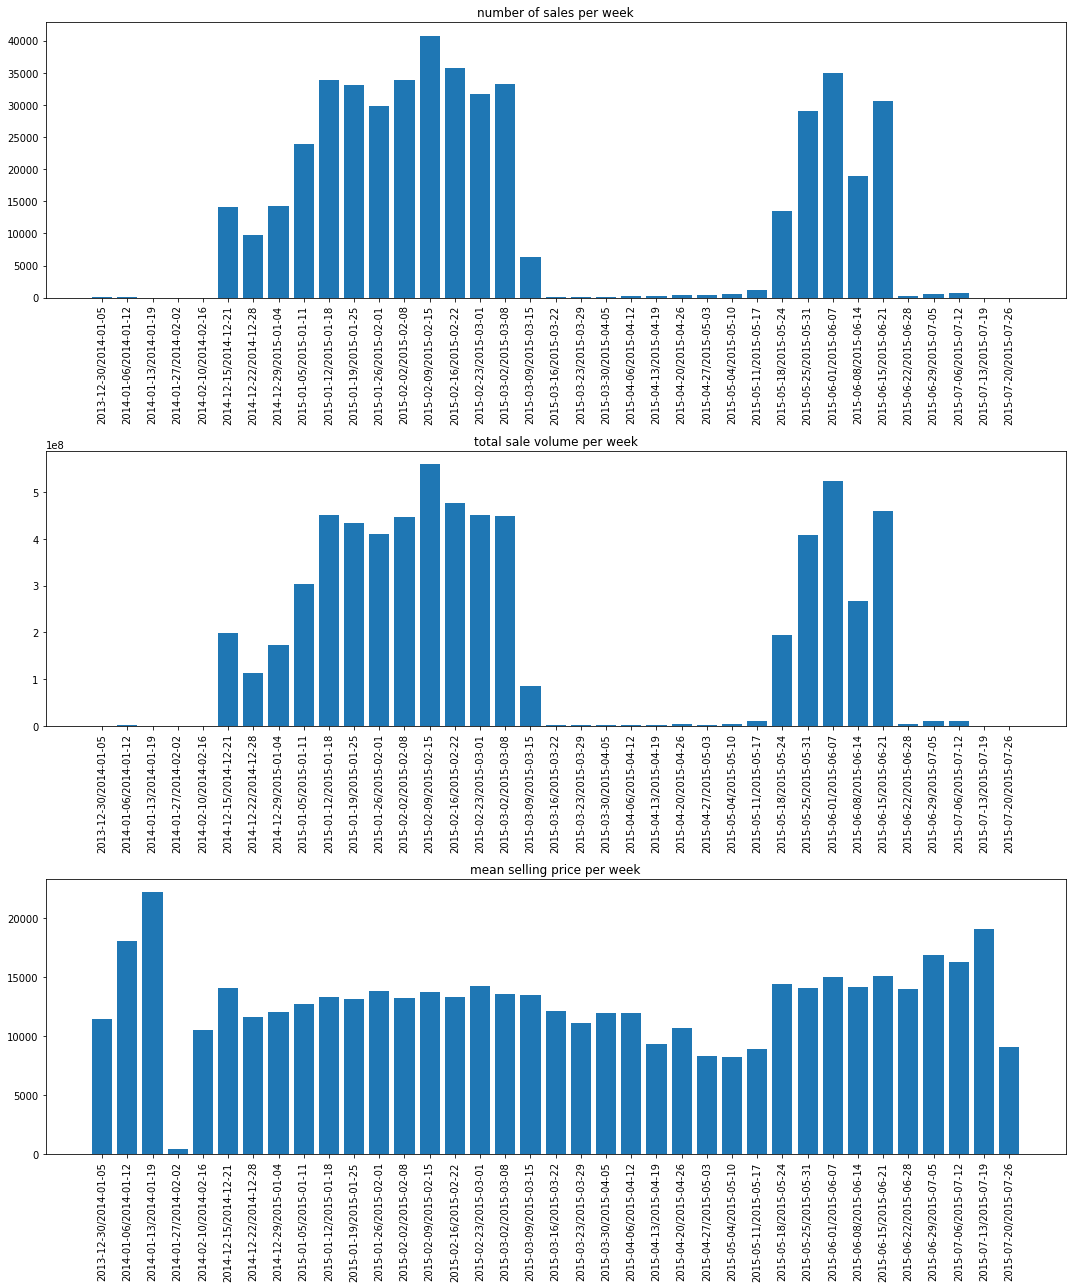

In [62]:
fig, ax = plt.subplots(3,1, figsize=(15,18))

data_time_base = data_cars['sellingprice'].groupby(data_cars['saledate'].dt.to_period('w'))
data_time = data_time_base.count()

bars = ax[0].bar(data_time.index.to_series().astype(str), data_time)
#ax[0].bar_label(bars, rotation = 90)
ax[0].tick_params(axis='x', labelrotation = 90)
ax[0].set_title('number of sales per week', fontsize=12)


data_time = data_time_base.sum()

bars = ax[1].bar(data_time.index.to_series().astype(str), data_time)
#ax[0].bar_label(bars, rotation = 90, label_type='center')
ax[1].tick_params(axis='x', labelrotation = 90)
ax[1].set_title('total sale volume per week', fontsize=12)



data_time = data_time_base.mean()

bars = ax[2].bar(data_time.index.to_series().astype(str), data_time)
#ax[1].bar_label(bars, rotation = 90, label_type='center')
ax[2].tick_params(axis='x', labelrotation = 90)
ax[2].set_title('mean selling price per week', fontsize=12)
plt.tight_layout()
plt.show()

## Conclusion

#### Vehicle selling prices are highly dependable on a number of attributes. The price, a vehicle can achieve is most likely higher if one or multiple of the following attributes apply:
- less mileage
- more recent manufacturing year
- better condition rating
- sold in specific US states (e.g.: Florida, California)
- specific manufacturer (e.g.: Rolls-Royce, Ferrari, Tesla)

#### Some attributes are more often represented in sold cars than other:
- more vehicles sold in less bright colors like black, grey and beige
- more vehicles are sold with automatic gear than with manual gear


## Selling price prediction

In [63]:
#used_features = ['yearScaled', 'trimID' ,'conditionScaled', 'odometerScaled', 'makeID', 'modelID',
# 'bodyID', 'transmissionID', 'stateID', 'colorID', 'interiorID', 'sellerID']
test_size = 0.3

print(used_features)

y = data_cars['sellingprice'].to_numpy()
x = data_cars[used_features]#.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)

print(x.shape, y.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


# indices for displaying prediction accuracy plots
indices = random.sample(range(len(y_test)), 100)
random_trues =  np.take(list(y_test), indices)

['year_Scaled', 'condition_Scaled', 'odometer_Scaled', 'makeID_Scaled', 'modelID_Scaled', 'trimID_Scaled', 'bodyID_Scaled', 'transmissionID_Scaled', 'stateID_Scaled', 'colorID_Scaled', 'interiorID_Scaled', 'sellerID_Scaled']
(472325, 12) (472325,)
(330627, 12) (141698, 12) (330627,) (141698,)


R2 = 0.4460840288249659 	 RMSE = 7181.0375253797065


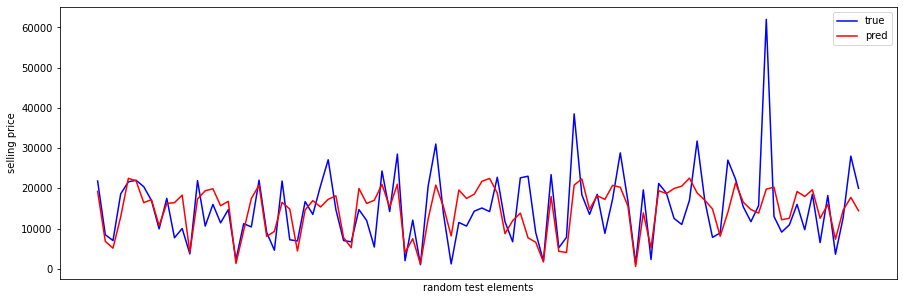

In [64]:
#Linear Regression Prediction

model = LinearRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(f'R2 = {r2_score(y_test, y_pred)} \t RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')

random_preds = np.take(y_pred, indices)

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(range(len(random_trues)), random_trues, color='blue', label="true")
ax1.plot(range(len(random_preds)), random_preds, color='red', label="pred")#, alpha=0.7)
plt.xlabel('random test elements')
plt.ylabel('selling price')
plt.xticks([])
plt.legend()
plt.show()

# R2 = 0.4460840288249659 	 RMSE = 7181.0375253797065

R2 = 0.4460840182698439 	 RMSE = 7181.037593798683


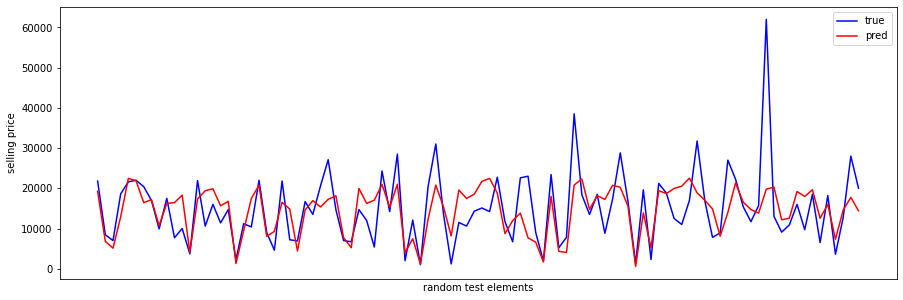

In [65]:
#Ridge Regression Prediction

model = Ridge()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(f'R2 = {r2_score(y_test, y_pred)} \t RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')

random_preds = np.take(y_pred, indices)

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(range(len(random_trues)), random_trues, color='blue', label="true")
ax1.plot(range(len(random_preds)), random_preds, color='red', label="pred")
plt.xlabel('random test elements')
plt.ylabel('selling price')
plt.xticks([])
plt.legend()
plt.show()

# R2 = 0.41020952081273265 	 RMSE = 7409.930442855528

R2 = 0.4460796400177177 	 RMSE = 7181.065973852718


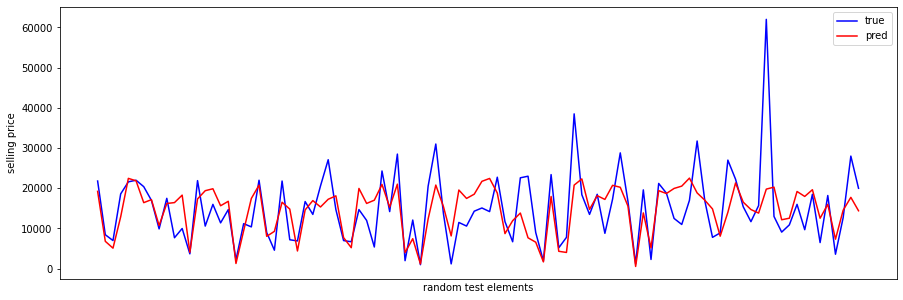

In [66]:
#Lasso Regression Prediction <-- linear

model = Lasso()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(f'R2 = {r2_score(y_test, y_pred)} \t RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')

random_preds = np.take(y_pred, indices)

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(range(len(random_trues)), random_trues, color='blue', label="true")
ax1.plot(range(len(random_preds)), random_preds, color='red', label="pred")
plt.xlabel('random test elements')
plt.ylabel('selling price')
plt.xticks([])
plt.legend()
plt.show()

# R2 = 0.41020449502178 	 RMSE = 7409.962013967099

R2 = 0.7513760172200572 	 RMSE = 4811.01556652055


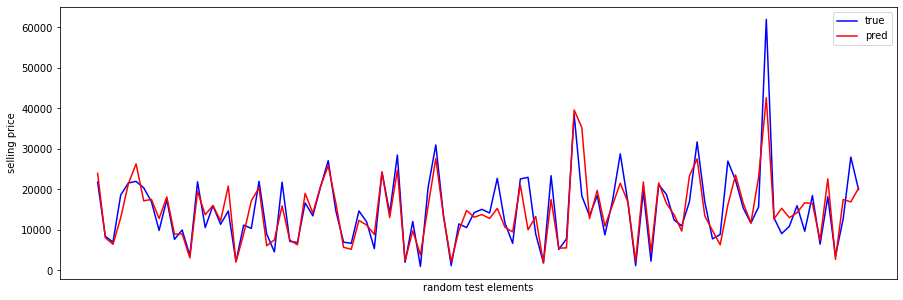

In [67]:
#K-Nearest Neighbour Prediction

model = KNeighborsRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(f'R2 = {r2_score(y_test, y_pred)} \t RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')

random_preds = np.take(y_pred, indices)

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(range(len(random_trues)), random_trues, color='blue', label="true")
ax1.plot(range(len(random_preds)), random_preds, color='red', label="pred")
plt.xlabel('random test elements')
plt.ylabel('selling price')
plt.xticks([])
plt.legend()
plt.show()

# R2 = 0.7513760172200572 	 RMSE = 4811.01556652055

R2 = 0.9533475409061933 	 RMSE = 2084.023072797137


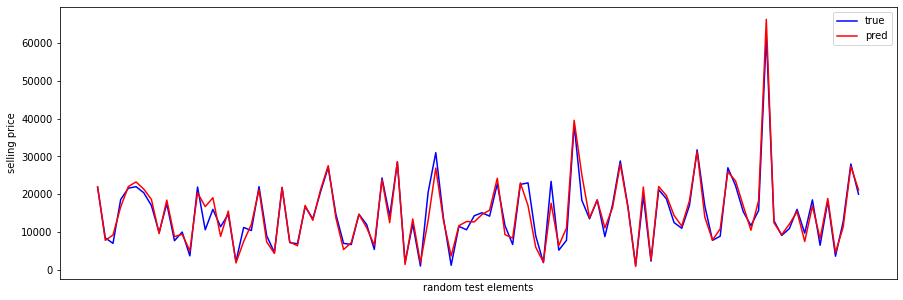

In [68]:
#Random Forest Prediction
model_rv = RandomForestRegressor()
model_rv.fit(x_train, y_train)
y_pred = model_rv.predict(x_test)
print(f'R2 = {r2_score(y_test, y_pred)} \t RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')

random_preds = np.take(y_pred, indices)

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(range(len(random_trues)), random_trues, color='blue', label="true")
ax1.plot(range(len(random_preds)), random_preds, color='red', label="pred")
plt.xlabel('random test elements')
plt.ylabel('selling price')
plt.xticks([])
plt.legend()
plt.show()

# R2 = 0.9533475409061933 	 RMSE = 2084.023072797137

C:\Users\Nadine\.conda\envs\pytorch_project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


R2 = 0.5644530634763565 	 RMSE = 6367.702049639539


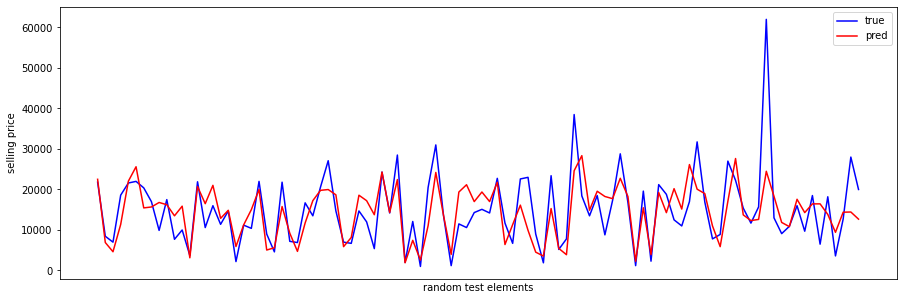

In [69]:
# Multi-Layer Perceptron Regressor
num_epochs = 200

model = MLPRegressor(random_state=0, max_iter=num_epochs).fit(x_train,y_train)

y_pred = model.predict(x_test)
print(f'R2 = {r2_score(y_test, y_pred)} \t RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')

random_preds = np.take(y_pred, indices)
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(range(len(random_trues)), random_trues, color='blue', label="true")
ax1.plot(range(len(random_preds)), random_preds, color='red', label="pred")
plt.xlabel('random test elements')
plt.ylabel('selling price')
plt.xticks([])
plt.legend()
plt.show()

# 200 epochs not converged yet --> R2 = 0.5644530634763565 	 RMSE = 6367.702049639539


Running the MLPRegressor model for 200 epochs (the prediction accuracy has not converged yet, so a further improvement is still probable) produces a RMSE score of 6237.7 and a R2 score of 0.5644.


### Performance comparison of the Regressor models

- Linear: R2 = 0.4460840288249659 	 RMSE = 7181.0375253797065
- Ridge: R2 = 0.4460840182698439 	 RMSE = 7181.037593798683
- Lasso: R2 = 0.4460796400177177 	 RMSE = 7181.065973852718
- KNN: R2 = 0.7513760172200572 	 RMSE = 4811.01556652055
- Random Forest: R2 = 0.9533475409061933 	 RMSE = 2084.023072797137


The Random Forest Regressor is able to make the most accurate selling price predictions with a RMSE score of 2085 and a R2 score of 0.953 .
The linear regression models (Linear, Ridge, Lasso) perform the worst with RMSE scores of 7409 and R2 scores of 0.41.



### Testing a simple self-written Regression model

In [73]:
n_epochs = 100
batch_size = 64
lr = 0.01
input_dim = len(used_features)
first_dim = 24
second_dim = 12
third_dim = 6

model = nn.Sequential(
    nn.Linear(input_dim, first_dim),
    nn.ReLU(),
    nn.Linear(first_dim, second_dim),
    nn.ReLU(),
    nn.Linear(second_dim, third_dim),
    nn.ReLU(),
    nn.Linear(third_dim, 1)
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [74]:

class CarDataset(Dataset):
    def __init__(self, features, prices):
        super(CarDataset, self).__init__()
        self.features = torch.from_numpy(np.array(features)).type(torch.float32)
        self.prices = torch.from_numpy(np.array(prices)).type(torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.prices[idx]

In [75]:
traindata = CarDataset(x_train, y_train)
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

testdata = CarDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=128, 
                         shuffle=False, num_workers=0)

In [ ]:
best_rmse = 10000000
best_epoch = 0

logdir_time = f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
logdir = os.path.join('logs', logdir_time)
os.mkdir(logdir)

    
with open(os.path.join(logdir, 'hparams.txt'), "a") as log_file:
    log_file.write(f"n_epochs:{n_epochs}\nbatch_size:{batch_size}\nlr:{lr}\nfeatures:{used_features}\nfirst_dim:{first_dim}\nsecond_dim:{second_dim}\nthird_dim:{third_dim}\ntest_size:{test_size}\n")
    
  
open(os.path.join(logdir, 'log.txt'), "w").close()
    
    
for epoch in range(n_epochs):
    trues = []
    preds = []
    model.train()
    for data in tqdm(trainloader, desc= f'Epoch {epoch}'):
        x_batch, y_batch = data
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        for data in tqdm(testloader):
            x_batch, y_batch = data
            y_pred = model(x_batch)
            mse_loss = loss_fn(y_pred, y_batch)
            trues.extend(y_batch)
            preds.extend(y_pred)
    
    preds = torch.cat(preds)
    trues = torch.cat(trues)
    r2 = R2Score()
    r2 = r2(preds, trues)
    rmse = MeanSquaredError(squared=False)
    rmse = rmse(preds, trues)
    
    if rmse < best_rmse:
        try:
            os.remove(f'{logdir}/model_epoch{best_epoch}.pth')
        except:
            pass
        best_rmse = rmse
        best_epoch = epoch
        torch.save(model.state_dict(), f'{logdir}/model_epoch{epoch}.pth')
    
    with open(os.path.join(logdir, 'log.txt'), "a") as log_file:
        log_file.write(f'Epoch {epoch}: R2={r2}, RMSE={rmse}\n')
    
    print(f'RMSE = {rmse} \t R2 = {r2}')
    
    random_trues = trues[indices]
    random_preds = preds[indices]

    fig, ax1 = plt.subplots(figsize=(15,5))

    trues = trues.tolist()
    ax1.plot(range(len(random_trues)), random_trues, color='blue', label="true")
    ax1.plot(range(len(random_preds)), random_preds, color='red', label="pred")
    plt.xlabel('random test elements')
    plt.ylabel('selling price')
    plt.xticks([])
    plt.legend()
    plt.savefig(os.path.join(logdir, f'Epoch_{epoch}.png'))
    plt.show()
    
print(f"best rmse: {best_rmse} in Epoch {best_epoch}")
    
# after 100 epochs, best scores: R2=0.8057751059532166, RMSE=4252.2392578125


Running the unoptimised model for 100 epochs produces a best RMSE score of 4252 and a R2 score of 0.805 in Epoch 96 while possibly still increasing in performance with further training.

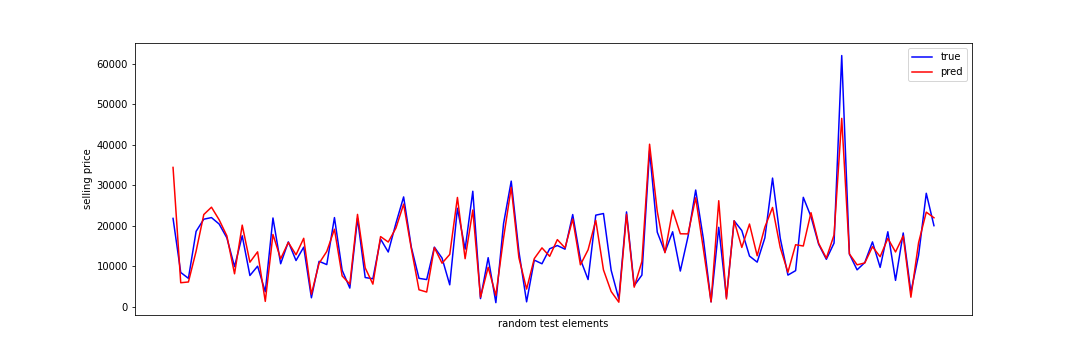